# Effect of Yesterday's Load on Performance and Wellness

After applying mixed models with random intercepts and GEE, one other interesting thing to explore owuld be to see if there is any specific relationship between yesterday's training load on the performance and wellness.<br><br>
In this notebook we will investigate this by first creating the proper dataset that includes yesterday's daily loads,  then merging it with wellness or performance data and then applying GEEs and random mixed models to find the best fit and compare their coefficients.


In [1]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot
import warnings


## Reading data

In [2]:
rpe_df = pd.read_csv('./processed_data/processed_rpe.csv')
rpe_df = rpe_df.drop(columns=['Unnamed: 0'])
print(rpe_df.head())

         Date  PlayerID  Training SessionType  Duration  RPE  SessionLoad  \
0  2017-08-01        15         1    Strength      60.0  4.0        240.0   
1  2017-08-01         1         1       Speed      60.0  3.0        180.0   
2  2017-08-01         1         1    Strength      90.0  4.0        360.0   
3  2017-08-01         3         1       Speed      45.0  5.0        225.0   
4  2017-08-01         3         1    Strength      90.0  5.0        450.0   

   DailyLoad  AcuteChronicRatio  ObjectiveRating  FocusRating  \
0      300.0               4.29              6.0          7.0   
1      540.0               4.29              0.0          0.0   
2      540.0               4.29              0.0          0.0   
3      675.0               4.29              7.0          7.0   
4      675.0               4.29              7.0          7.0   

   BestOutOfMyself  AcuteLoad  ChronicLoad  
0              2.0      42.86         10.0  
1              2.0      77.14         18.0  
2          

In [3]:
wellness_df = pd.read_csv('./processed_data/processed_wellness.csv')
wellness_df = wellness_df.drop(columns=['Unnamed: 0'])
print(wellness_df.head())

         Date  PlayerID  MonitoringScore  Fatigue  Soreness  Desire  \
0  2018-07-21         1               13        3         3       2   
1  2018-07-21         2               19        4         3       4   
2  2018-07-21         3               19        3         3       5   
3  2018-07-21         4               15        2         3       5   
4  2018-07-21         5               20        5         3       4   

   Irritability  SleepHours  SleepQuality  Menstruation  ...  Nutrition  \
0             3        8.00             2             0  ...          3   
1             4        8.00             4             0  ...          3   
2             4        8.00             4             1  ...          3   
3             4        6.50             1             0  ...          3   
4             4        7.25             4             1  ...          2   

   TrainingReadiness  StandardizedMonitoringScore  StandardizedPain  \
0                  0                    -1.448934  

In [4]:
gps_df = pd.read_csv('./processed_data/processed_gps.csv')
gps_df = gps_df.drop(columns=['Unnamed: 0'])
print(gps_df.head())

         Date  GameID Outcome  TeamPoints  PlayerID  MaxSpeedInGame  \
0  2017-11-30       1       W          19         2        7.284728   
1  2017-11-30       1       W          19         3        6.852436   
2  2017-11-30       1       W          19         4        7.267784   
3  2017-11-30       1       W          19         6        6.338894   
4  2017-11-30       1       W          19         7        7.065283   

   MaxAccelImpulseInGame  
0               4.423615  
1               4.888893  
2               5.694449  
3               4.777782  
4               4.091273  


## Create yesterday's dataset

To do this we can just shift the dates by 1 day and then merge iy with the wellness or performance data. This way for ech day in the new merged datsets we will basically have yesterday's training load.

In [5]:
yesterday_rpe = rpe_df.copy()[['Date','PlayerID','Training','SessionLoad','RPE','DailyLoad']]
yesterday_rpe['Date'] = pd.to_datetime(yesterday_rpe['Date'], format='%Y-%m-%d')

# Add one day to all dates
yesterday_rpe['Date'] = pd.DatetimeIndex(yesterday_rpe['Date']) + pd.DateOffset(1)
yesterday_rpe = yesterday_rpe.rename(columns = {'DailyLoad':'YesterdayLoad'})

yesterday_rpe.head()

,Date,PlayerID,Training,SessionLoad,RPE,YesterdayLoad
0,2017-08-02,15,1,240.0,4.0,300.0
1,2017-08-02,1,1,180.0,3.0,540.0
2,2017-08-02,1,1,360.0,4.0,540.0
3,2017-08-02,3,1,225.0,5.0,675.0
4,2017-08-02,3,1,450.0,5.0,675.0


# Training load on the day before and today's wellness

To do this we first need to merge the data with wellness data:

In [6]:
wellness_df['Date'] = pd.to_datetime(wellness_df['Date'],format='%Y-%m-%d')

# Merge yesterday training load with wellness data
wellness_with_yesterday_training = yesterday_rpe.merge(wellness_df,
    how='inner', on= ['Date','PlayerID'])[['Date','PlayerID','YesterdayLoad',
                                           'MonitoringScore','TrainingReadiness',
                                           'Pain','Illness','Nutrition',
                                           'wellness']].drop_duplicates()


In [7]:
# Sanity check
wellness_with_yesterday_training[(wellness_with_yesterday_training['PlayerID'] == 1)]

,Date,PlayerID,YesterdayLoad,MonitoringScore,TrainingReadiness,Pain,Illness,Nutrition,wellness
315,2017-08-17,1,0.0,19,80,1,3,3,1.583096
346,2017-08-18,1,510.0,20,85,1,3,3,1.852998
378,2017-08-19,1,1230.0,21,0,1,3,3,2.122900
408,2017-08-20,1,0.0,20,100,1,3,3,1.852998
454,2017-08-22,1,670.0,17,85,1,3,3,1.043291
493,2017-08-23,1,1080.0,17,70,1,3,3,1.043291
520,2017-08-24,1,0.0,16,85,1,3,3,0.773389
586,2017-08-26,1,1020.0,17,0,1,3,3,1.043291
610,2017-08-27,1,0.0,18,0,1,3,3,1.313193
620,2017-08-28,1,0.0,20,75,1,3,3,1.852998


In [8]:
processed_wellness = wellness_with_yesterday_training.copy()

# Since wellness values are really small we need to rescale training loads as well
processed_wellness['YesterdayLoad'] = StandardScaler().fit_transform(wellness_with_yesterday_training[['YesterdayLoad']])

processed_wellness[(processed_wellness['PlayerID'] == 2)]

,Date,PlayerID,YesterdayLoad,MonitoringScore,TrainingReadiness,Pain,Illness,Nutrition,wellness
316,2017-08-17,2,-0.921055,18,80,1,3,2,-0.594231
343,2017-08-18,2,1.005407,19,75,1,3,3,1.583096
385,2017-08-19,2,1.701718,22,0,1,3,3,2.392802
409,2017-08-20,2,-1.013897,23,0,0,3,2,-2.356870
423,2017-08-21,2,-1.013897,20,85,1,3,2,-0.054427
450,2017-08-22,2,0.309095,23,90,1,3,3,2.662704
488,2017-08-23,2,0.935775,18,65,1,3,3,1.313193
517,2017-08-24,2,-0.909450,19,75,1,3,2,-0.324329
550,2017-08-25,2,0.657251,22,90,1,3,2,0.485378
581,2017-08-26,2,1.075038,22,0,1,3,3,2.392802


Before applying any model, it is again a good idea to visualize yesterday's load vs wellness over all days for each players to see if we can observe any obvious relationship or pattern.

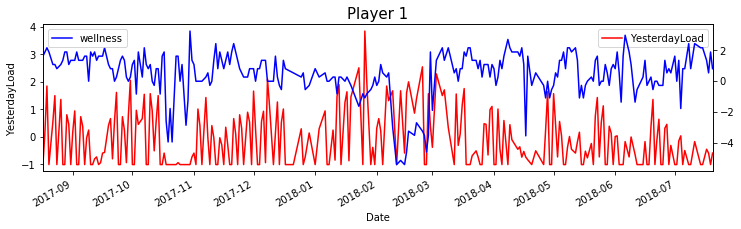

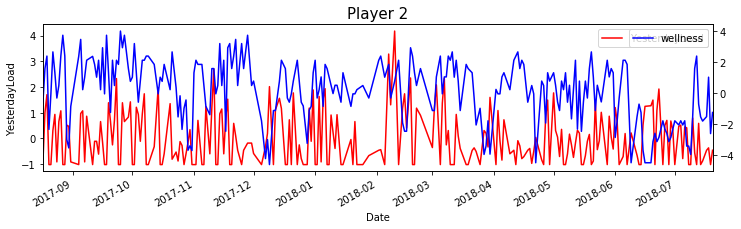

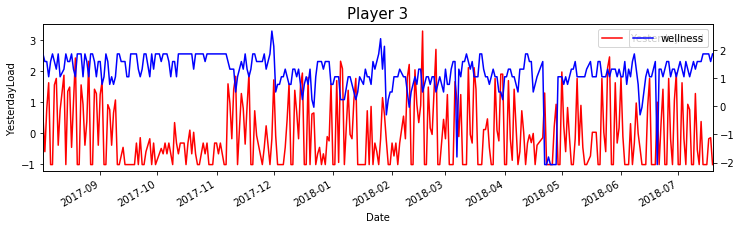

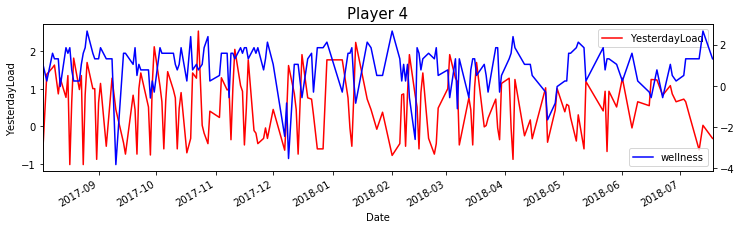

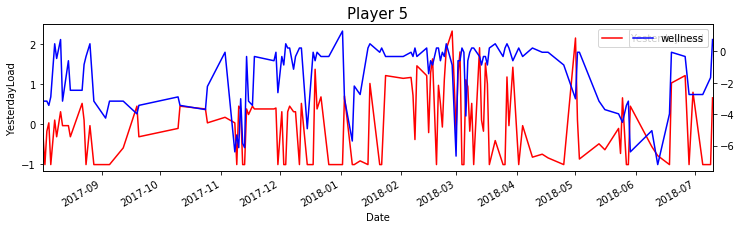

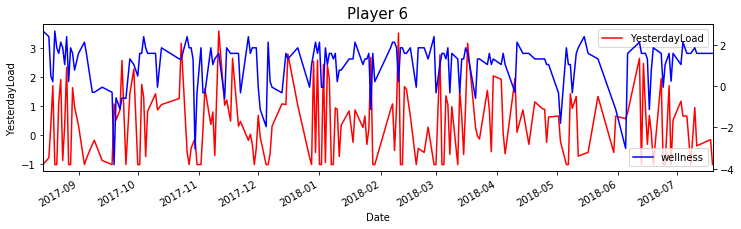

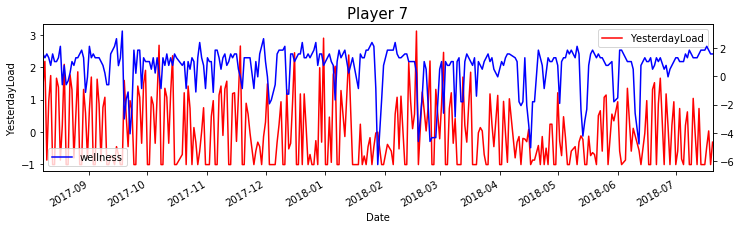

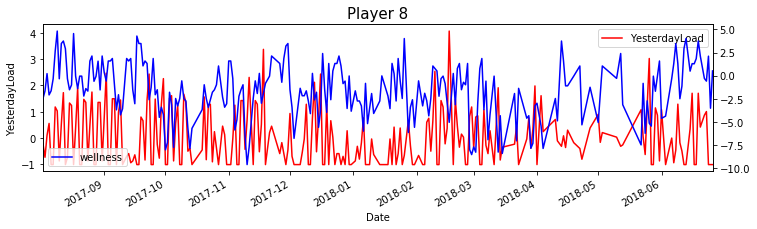

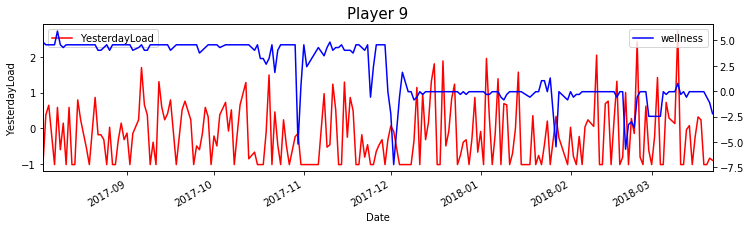

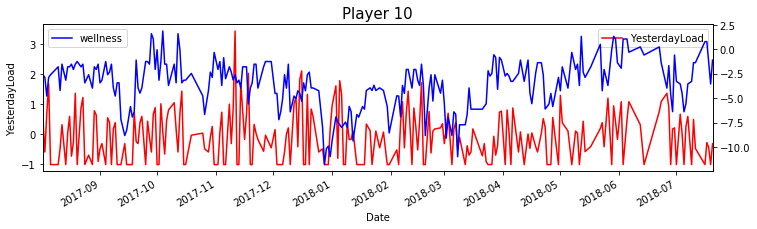

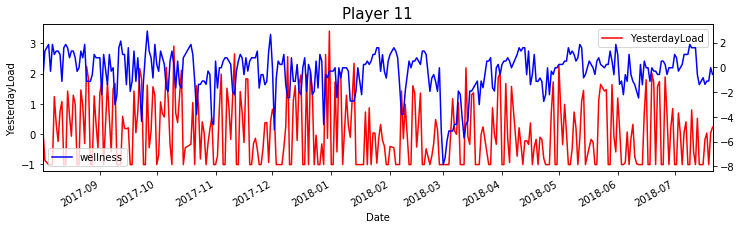

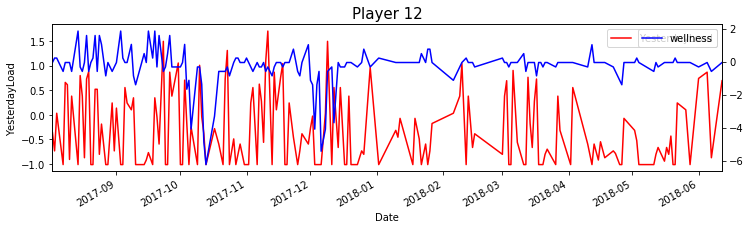

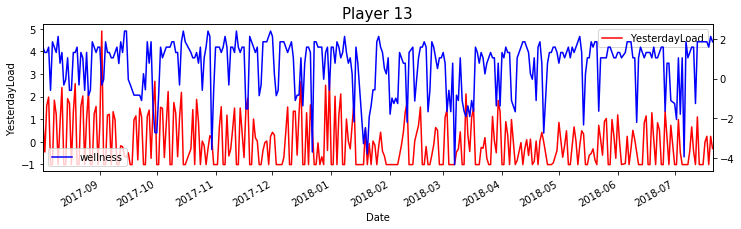

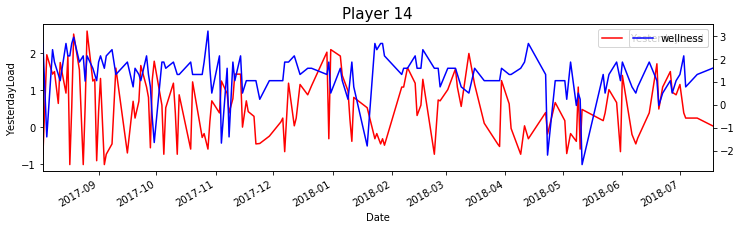

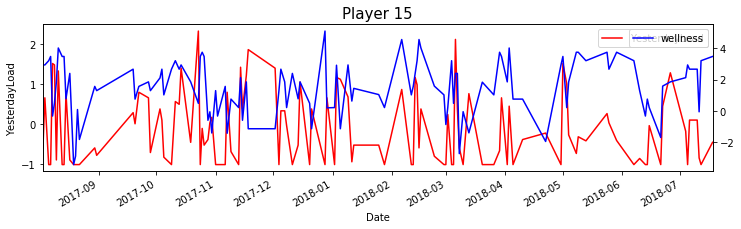

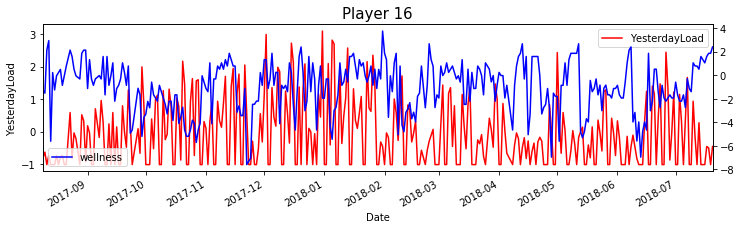

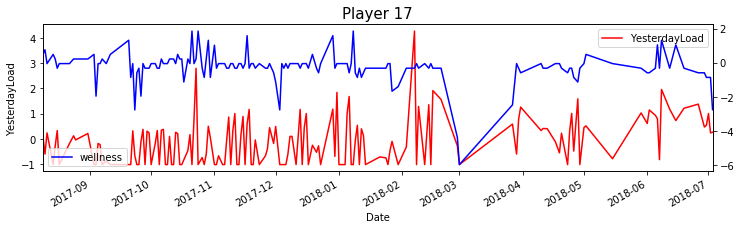

In [9]:
grouped = processed_wellness.groupby(['PlayerID'])

for name,group in grouped:
    fig = plt.figure(figsize=(12,3))
    ax1 = fig.add_subplot(111)

    group.plot.line(ax=ax1, color='red',x="Date",y="YesterdayLoad")
    ax1.set_ylabel('YesterdayLoad')
    ax3 = ax1.twinx()
    group.plot.line(ax=ax3, color='blue',x="Date",y="wellness")

    ax1.set_title('Player ' + str(name), fontsize=15)

plt.show()
plt.close()

Just based on the graphs it is hard to see any specific pattern, so let's invetigate this further by applying GEEs and random intercept mixed models.

In [10]:
# Helper function to draw scatter plots given the dataframe and appropriate columns
def scatter_plot(df, x, y, title=None):
    df.plot.scatter(x, y)
    if title:
        plt.title(title)
    plt.show()
    

# Helper function to remove the outliers based on the IQR rule
def removeOutliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    new_df = df[(df[column_name] > Q1 - (1.5 * IQR)) & 
                (df[column_name] < Q3 + (1.5 * IQR))]
    return new_df    

In [27]:
processed_wellness['wellness']

0       1.852998
2      -3.166577
4      -2.493612
6      -2.608663
8      -0.864133
10     -0.054427
12      1.583096
14      1.583096
15      1.043291
16     -1.665796
18     -3.166577
19      1.313193
20      0.215476
21      1.313193
23      2.662704
24      2.932606
25     -2.878565
26      4.552019
28      0.215476
31      1.583096
34     -3.166577
39      1.313193
43      0.215476
46      2.932606
49     -2.086968
52      1.043291
55      0.233585
58     -3.436479
60      4.552019
63     -1.403937
          ...   
8264    0.503487
8266    1.025182
8268    1.583096
8269    1.313193
8270    1.583096
8272   -1.377785
8273    1.852998
8274   -1.107883
8275    1.852998
8277    1.583096
8278    3.472411
8279    1.852998
8281    1.852998
8282    1.852998
8283   -2.626772
8284    1.583096
8285    1.583096
8286   -3.555111
8287   -1.107883
8288    1.852998
8289    1.583096
8290    0.773389
8291   -1.259152
8292   -1.107883
8293   -0.028274
8294    2.122900
8296    2.392802
8297    1.5830

                               GEE Regression Results                              
Dep. Variable:                    wellness   No. Observations:                 3802
Model:                                 GEE   No. clusters:                       17
Method:                        Generalized   Min. cluster size:                 115
                      Estimating Equations   Max. cluster size:                 342
Family:                           Gaussian   Mean cluster size:               223.6
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                     Tue, 10 Dec 2019   Scale:                           2.850
Covariance type:                    robust   Time:                         15:06:46
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.3167      0.244      1.298      0.194      -0.162       0.79

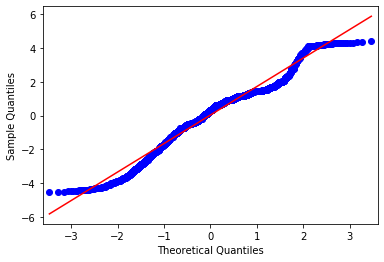

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


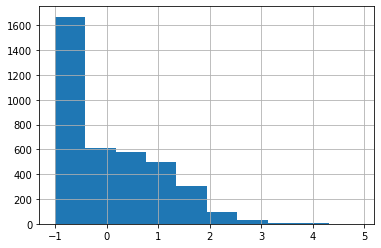

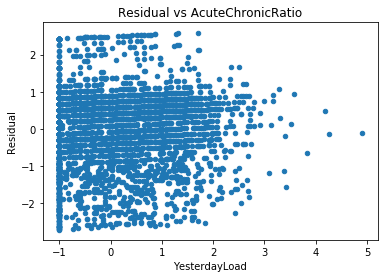

In [11]:
fam = sm.families.Gaussian()
ind = sm.cov_struct.Exchangeable()

processed_wellness = removeOutliers(processed_wellness, 'wellness')


mod = smf.gee("wellness ~ YesterdayLoad", "PlayerID", processed_wellness, cov_struct=ind, family=fam)
res = mod.fit()
print(res.summary())
qqplot(res.resid, line='s')
plt.show()

processed_wellness['Residual'] = (res.resid - res.resid.mean()) / res.resid.std()
processed_wellness['YesterdayLoad'].hist()

scatter_plot(processed_wellness, 'YesterdayLoad', 'Residual', 'Residual vs AcuteChronicRatio')

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: wellness  
No. Observations: 3802    Method:             REML      
No. Groups:       17      Scale:              2.0222    
Min. group size:  115     Likelihood:         -6775.8991
Max. group size:  342     Converged:          Yes       
Mean group size:  223.6                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.317    0.252  1.257 0.209 -0.177  0.810
YesterdayLoad -0.100    0.024 -4.267 0.000 -0.146 -0.054
Group Var      1.068    0.269                           



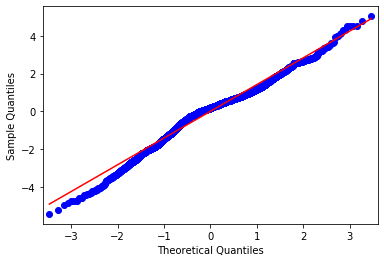

In [13]:
processed_wellness = processed_wellness.dropna()

mixed = smf.mixedlm("wellness ~ YesterdayLoad", processed_wellness, groups = processed_wellness["PlayerID"])
mixed_fit = mixed.fit()
print(mixed_fit.summary())
qqplot(mixed_fit.resid, line='s')
plt.show()

From the qqplots, we can see that the random mixed model is a better fit compared to the gee model. Even though the coefficients in both models are similiar.

In [14]:
processed_wellness['wellness'].std()

1.6884128811049652

In [15]:
processed_wellness['wellness'].quantile(0.25)

-0.5942309270254784

In [16]:
processed_wellness['wellness'].median()

0.5708464977819101

In [17]:
processed_wellness['wellness'].quantile(0.75)

1.583095610014444

In [18]:
processed_wellness['YesterdayLoad'].std()

0.9997023364257358

In [19]:
processed_wellness['YesterdayLoad'].quantile(0.25)

-1.0138967711581923

In [20]:
processed_wellness['YesterdayLoad'].quantile(0.4)

-0.561294285415534

In [21]:
processed_wellness['YesterdayLoad'].median()

-0.21313852715195056

In [22]:
processed_wellness['YesterdayLoad'].quantile(0.60)

0.1698328069379912

In [23]:
processed_wellness['YesterdayLoad'].quantile(0.75)

0.7500924040439635

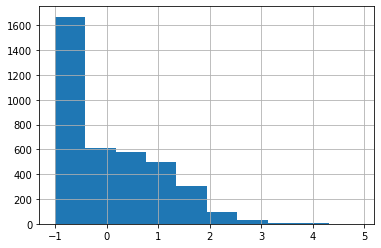

In [24]:
processed_wellness['YesterdayLoad'].hist()

# Performance vs yesterday's daily load

In [25]:
gps_df['Date'] = pd.to_datetime(gps_df['Date'],format='%Y-%m-%d')
speed_vs_yesterday_load = gps_df.merge(yesterday_rpe,
    how='inner', on= ['Date','PlayerID'])[['Date','PlayerID','YesterdayLoad','MaxSpeedInGame','MaxAccelImpulseInGame']].drop_duplicates()

processed_speed = speed_vs_yesterday_load.copy()
processed_speed = processed_speed[(processed_speed['MaxSpeedInGame'] >= 5) & (processed_speed['MaxSpeedInGame'] <= 9)]
processed_speed[['YesterdayLoad','MaxSpeedInGame','MaxAccelImpulseInGame']] = StandardScaler().fit_transform(processed_speed[['YesterdayLoad','MaxSpeedInGame','MaxAccelImpulseInGame']])


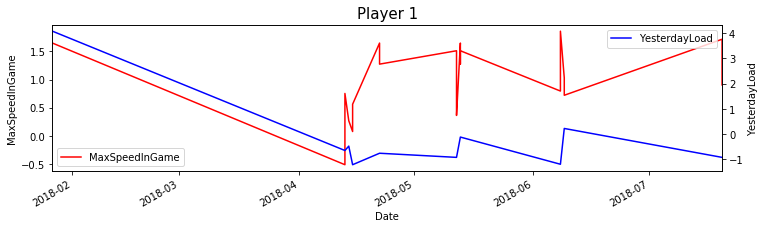

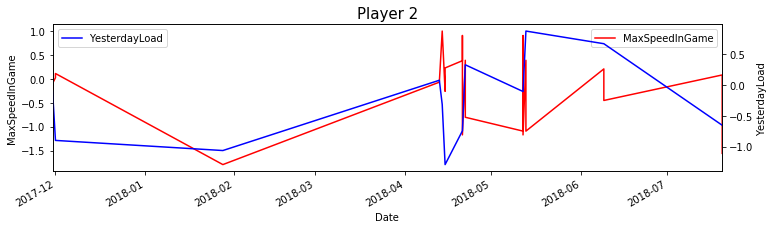

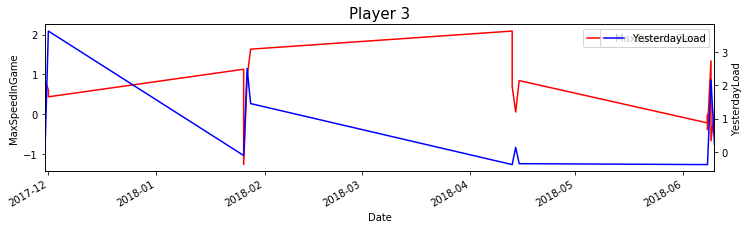

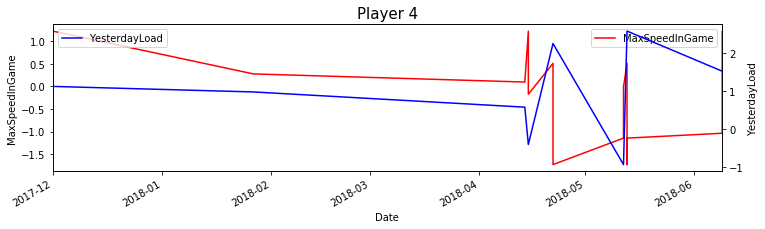

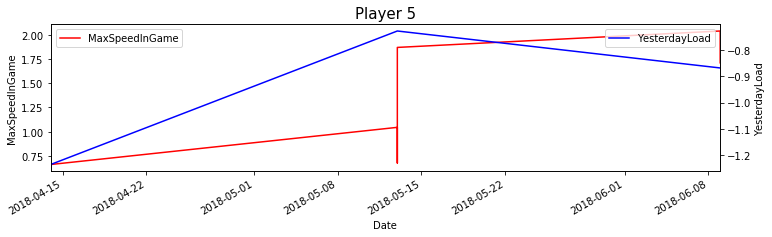

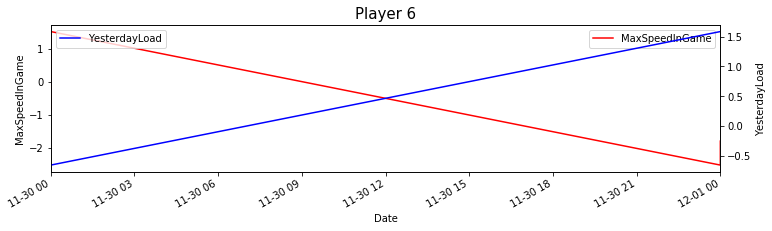

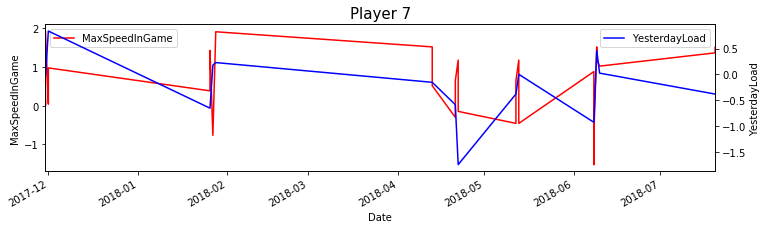

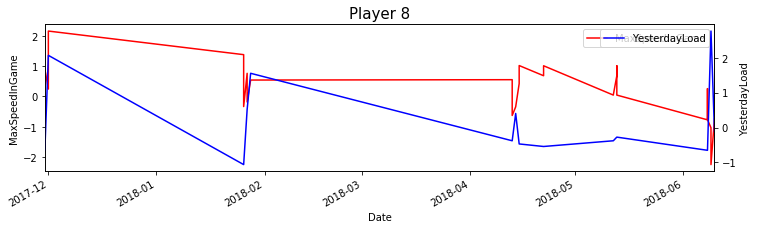

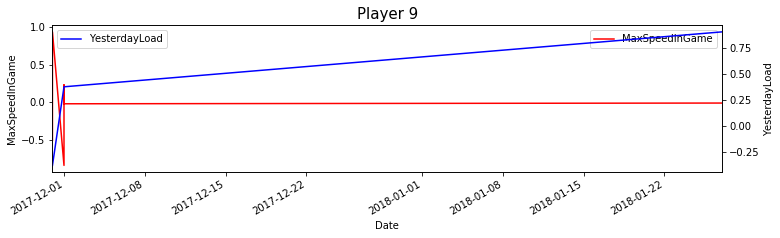

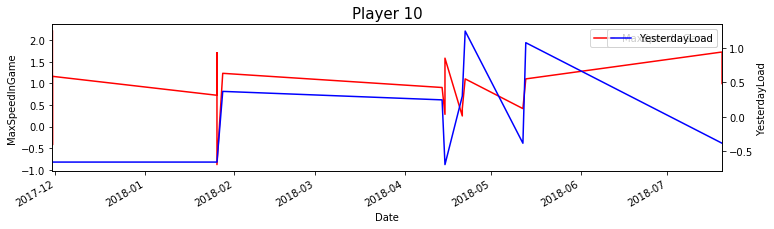

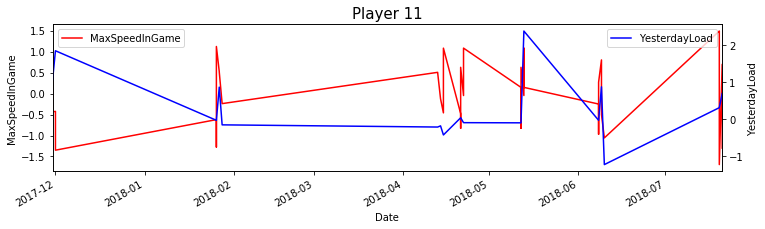

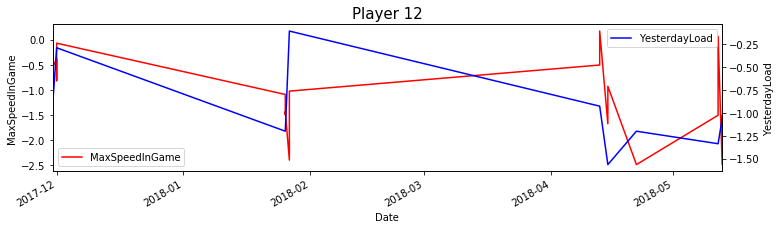

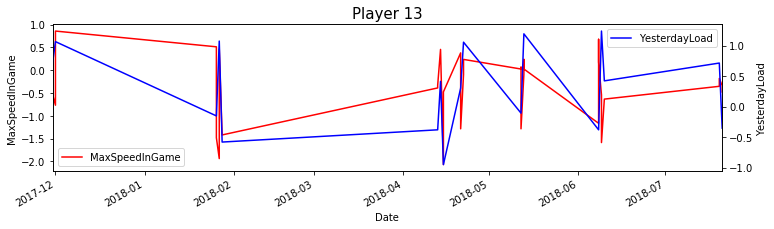

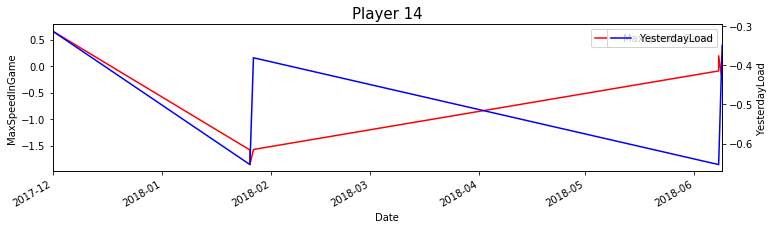

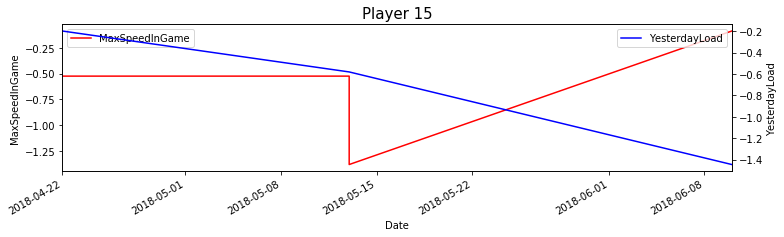

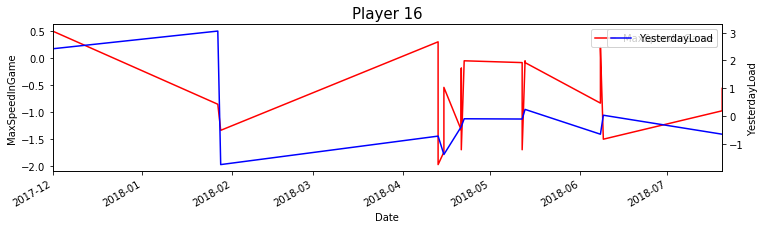

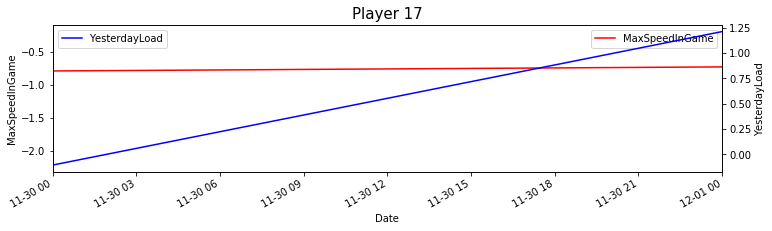

In [26]:
grouped = processed_speed.groupby(['PlayerID'])

for name,group in grouped:
    fig = plt.figure(figsize=(12,3))
    ax1 = fig.add_subplot(111)
    group.plot.line(ax=ax1, color='red',x="Date",y="MaxSpeedInGame")
    ax1.set_ylabel('MaxSpeedInGame')
    ax3 = ax1.twinx()
    group.plot.line(ax=ax3, color='blue',x="Date",y="YesterdayLoad")
    ax3.set_ylabel('YesterdayLoad')
    ax1.set_title('Player ' + str(name), fontsize=15)

plt.show()
plt.close()

In [ ]:
mod = smf.gee("MaxSpeedInGame ~ YesterdayLoad", "PlayerID", processed_speed, cov_struct=ind, family=fam)
res = mod.fit()
print(res.summary())
qqplot(res.resid, line='s')

In [ ]:
print(len(gps_df),len(processed_speed))
mixed = smf.mixedlm("MaxSpeedInGame ~ YesterdayLoad", processed_speed, groups = processed_speed["PlayerID"])
mixed_fit = mixed.fit()
print(mixed_fit.summary())
qqplot(mixed_fit.resid, line='s')

Previous day's daily load negativel affects today's performance as well as wellness.

In [ ]:
print(processed_speed['MaxSpeedInGame'].std())
print(processed_speed['YesterdayLoad'].std())
print(processed_speed['MaxSpeedInGame'].median())
print(processed_speed['YesterdayLoad'].median())
print(processed_speed['MaxSpeedInGame'].quantile(0.75))
print(processed_speed['YesterdayLoad'].quantile(0.75))